# _Skin Cancer Image Classification: Nov. 25, 2019_

In [1]:
# mount your Google Drive, giving us access to any files we have stored there
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
# import deep learning libraries
import torch
import fastai
from fastai import *
from fastai.vision import *

In [4]:
# import os library to better help us navigate directories (which in this) case is our Google Drive
import os

# what is our current working directory?
print("Our current working directory is '{}'.".format(os.getcwd()))

Our current working directory is '/content'.


In [5]:
# change our directory to the one associated with this project
os.chdir('/content/gdrive/My Drive/projects/skin-cancer')

# lets confirm that it updated the directory accordingly
os.getcwd()

'/content/gdrive/My Drive/projects/skin-cancer'

In [6]:
os.listdir()

['joetools', 'skin-data', 'models']

In [7]:
os.listdir('skin-data/')

['HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv',
 'skin-cancer-mnist-ham10000.zip',
 'HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'ham10000_images_part_1',
 'ham10000_images_part_2']

# _Create DataFrame_

In [8]:
from pathlib import Path

#create path variable to primary directory
path = Path(os.getcwd())
path

PosixPath('/content/gdrive/My Drive/projects/skin-cancer')

In [9]:
import pandas as pd

df = pd.read_csv(path/'skin-data/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
diagnosis_dict = {
    'akiec': 'Actinic keratoses', # potential pre-cancer
    'bcc': 'Basal cell carcinoma', # not so good
    'bkl': 'Benign keratosis', # benign is good
    'df': 'Dermatofibroma', # benign
    'mel': 'Melanoma', # very bad
    'nv': 'Melanocytic nevi', # common mole
    'vasc': 'Vascular lesions' # could be benign or malignant
    }

In [ ]:
df['diagnosis'] = df['dx'].map(diagnosis_dict)

In [ ]:
df['diagnosis'] = df['diagnosis'].astype('category')

In [13]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis


In [22]:
len(df)

10015

In [23]:
df['diagnosis'].value_counts(normalize=True)

Melanocytic nevi        0.669496
Melanoma                0.111133
Benign keratosis        0.109735
Basal cell carcinoma    0.051323
Actinic keratoses       0.032651
Vascular lesions        0.014179
Dermatofibroma          0.011483
Name: diagnosis, dtype: float64

# _Data Augmentation_

In [ ]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=True,
                      max_rotate=25,
                      max_zoom=1.0,
                      xtra_tfms=dihedral()
                      )

# _Create Sample_

In [ ]:
sample = df.sample(frac=0.25, random_state=1)

In [26]:
len(sample)

2504

In [27]:
sample['diagnosis'].value_counts(normalize=True)

Melanocytic nevi        0.663339
Benign keratosis        0.113019
Melanoma                0.108227
Basal cell carcinoma    0.048722
Actinic keratoses       0.033546
Vascular lesions        0.017173
Dermatofibroma          0.015974
Name: diagnosis, dtype: float64

# _Set Up `ImageDataBunch` for Sample Data_

In [15]:
(path/'skin-data').ls()

[PosixPath('/content/gdrive/My Drive/projects/skin-cancer/skin-data/HAM10000_metadata.csv'),
 PosixPath('/content/gdrive/My Drive/projects/skin-cancer/skin-data/hmnist_28_28_L.csv'),
 PosixPath('/content/gdrive/My Drive/projects/skin-cancer/skin-data/hmnist_28_28_RGB.csv'),
 PosixPath('/content/gdrive/My Drive/projects/skin-cancer/skin-data/hmnist_8_8_L.csv'),
 PosixPath('/content/gdrive/My Drive/projects/skin-cancer/skin-data/hmnist_8_8_RGB.csv'),
 PosixPath('/content/gdrive/My Drive/projects/skin-cancer/skin-data/skin-cancer-mnist-ham10000.zip'),
 PosixPath('/content/gdrive/My Drive/projects/skin-cancer/skin-data/HAM10000_images_part_1'),
 PosixPath('/content/gdrive/My Drive/projects/skin-cancer/skin-data/HAM10000_images_part_2'),
 PosixPath('/content/gdrive/My Drive/projects/skin-cancer/skin-data/ham10000_images_part_1'),
 PosixPath('/content/gdrive/My Drive/projects/skin-cancer/skin-data/ham10000_images_part_2')]

In [ ]:
sample_data = ImageDataBunch.from_df(
    path=path/'skin-data/HAM10000_images_part_1',
    df=sample, # take from sample dataframe
    valid_pct=0.2, 
    seed=1, 
    fn_col='image_id',
    label_col='diagnosis', 
    suffix='.jpg', 
    ds_tfms=tfms, 
    size=64,
    bs=32
)

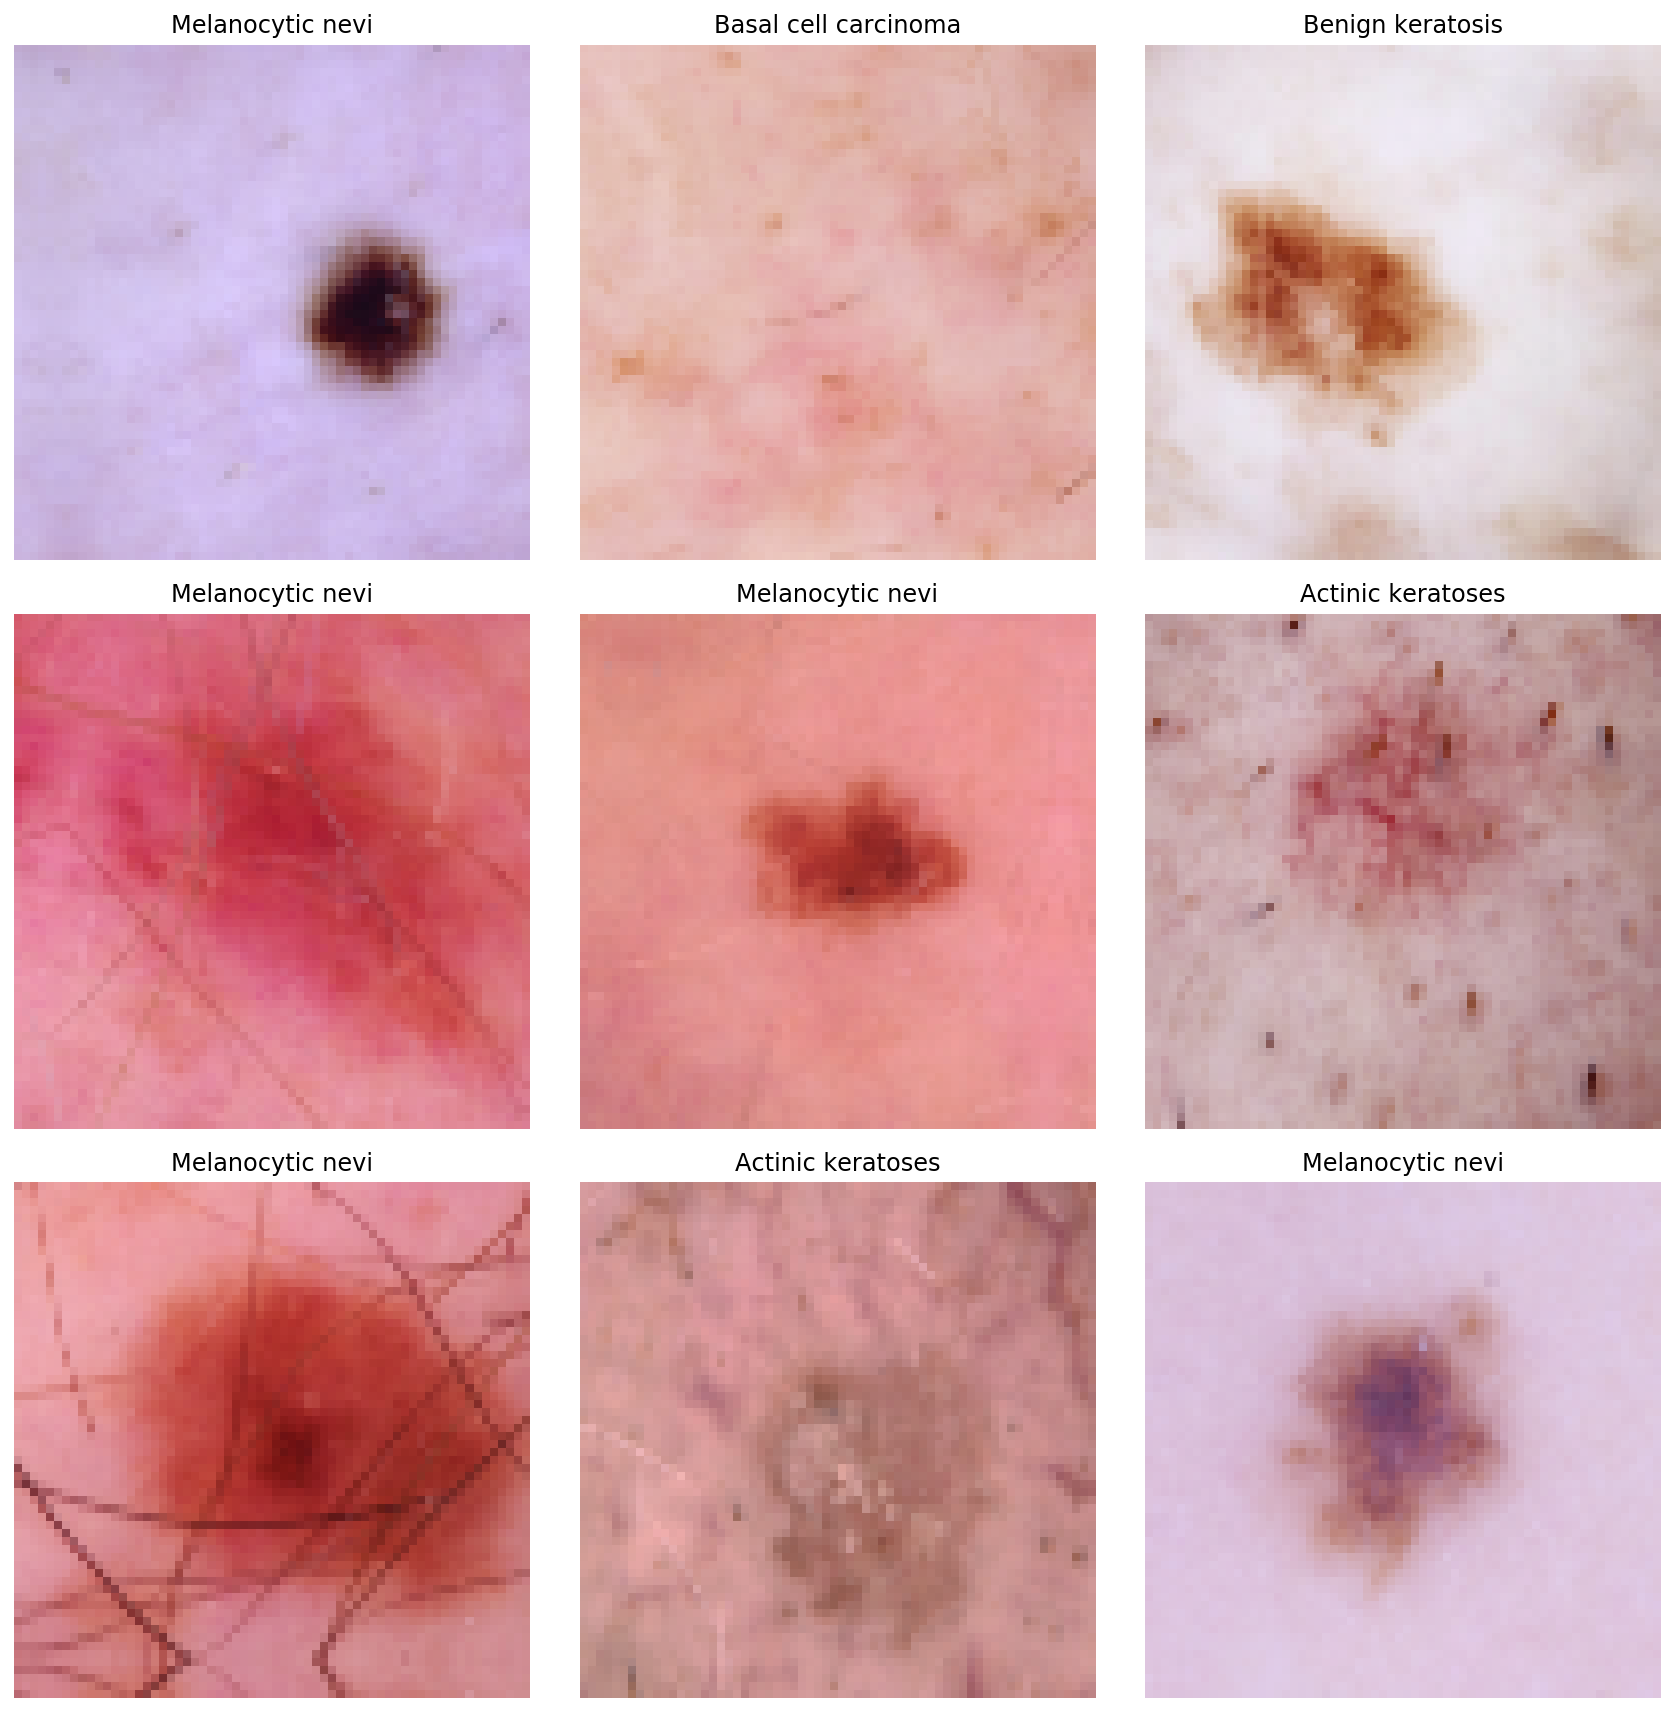

In [29]:
sample_data.show_batch(rows=3)

In [30]:
sample_data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (2004 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Melanocytic nevi,Melanocytic nevi,Melanocytic nevi,Melanocytic nevi,Melanocytic nevi
Path: /content/gdrive/My Drive/projects/skin-cancer/skin-data/HAM10000_images_part_1;

Valid: LabelList (500 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
Actinic keratoses,Benign keratosis,Melanocytic nevi,Melanoma,Melanocytic nevi
Path: /content/gdrive/My Drive/projects/skin-cancer/skin-data/HAM10000_images_part_1;

Test: None

# _Create Learner_

In [ ]:
learn = cnn_learner(
    data=sample_data,
    base_arch=models.resnet50,
    pretrained=True,
    metrics=[accuracy, Recall(), Precision()],
    path=path
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 3.98E-03


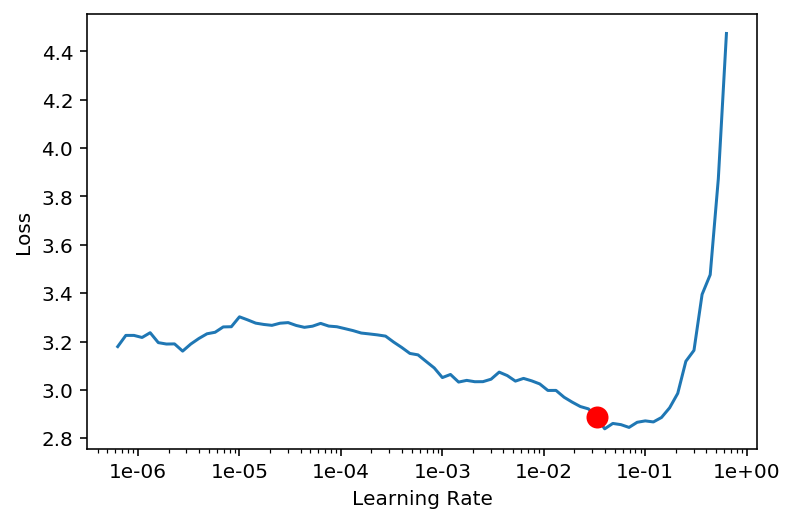

In [36]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr = 1e-2

In [38]:
from fastai.callbacks import SaveModelCallback

learn.fit_one_cycle(5, lr, callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                          monitor='accuracy', name='starting_sample'))])

epoch,train_loss,valid_loss,accuracy,recall,precision,time
0,2.133163,1.752451,0.630000,0.342188,0.286434,00:42
1,1.449458,0.827444,0.734000,0.403987,0.437407,00:42
2,1.098911,0.739345,0.738000,0.456524,0.650166,00:45
3,0.878990,0.674248,0.744000,0.493633,0.656074,00:40
4,0.755469,0.654908,0.766000,0.518745,0.576066,00:40


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.6299999952316284.
Better model found at epoch 1 with accuracy value: 0.734000027179718.
Better model found at epoch 2 with accuracy value: 0.7379999756813049.
Better model found at epoch 3 with accuracy value: 0.7440000176429749.
Better model found at epoch 4 with accuracy value: 0.765999972820282.


# _Create `data` object using all available images_

In [ ]:
data = ImageDataBunch.from_df(
    path=path/'skin-data/HAM10000_images_part_1',
    df=df, # take from full dataset
    valid_pct=0.2, 
    seed=1, 
    fn_col='image_id',
    label_col='diagnosis', 
    suffix='.jpg', 
    ds_tfms=tfms, 
    size=224,
    bs=32
)

In [ ]:
# load weights from training on sample
learn.load('starting_sample');

# reassign the new data object to the learner
learn.data = data

# _Train with all data_

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 3.63E-06


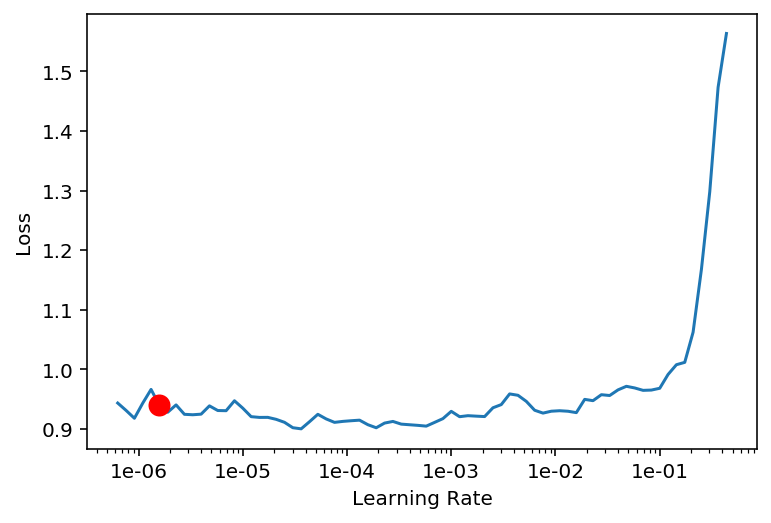

In [43]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [44]:
learn.fit_one_cycle(10, callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                      monitor='accuracy', name='trial3'))])

epoch,train_loss,valid_loss,accuracy,recall,precision,time
0,0.842660,0.685821,0.746880,0.399071,nan,23:04
1,0.791301,0.637772,0.767848,0.489530,0.550863,06:16
2,0.713191,0.657394,0.755367,0.429861,0.763299,06:19
3,0.690388,0.582942,0.779331,0.543446,0.702151,06:26
4,0.611157,0.548251,0.798303,0.597099,0.695125,06:20
5,0.592097,0.511069,0.810784,0.598512,0.740242,06:38
6,0.554587,0.497489,0.815277,0.625562,0.757472,06:46
7,0.519379,0.480683,0.821767,0.616008,0.766831,06:46
8,0.512030,0.470802,0.828258,0.637730,0.750572,06:26
9,0.483460,0.471477,0.830255,0.632167,0.768350,06:26


Better model found at epoch 0 with accuracy value: 0.7468796968460083.
Better model found at epoch 1 with accuracy value: 0.7678482532501221.
Better model found at epoch 3 with accuracy value: 0.7793310284614563.
Better model found at epoch 4 with accuracy value: 0.7983025312423706.
Better model found at epoch 5 with accuracy value: 0.8107838034629822.
Better model found at epoch 6 with accuracy value: 0.815277099609375.
Better model found at epoch 7 with accuracy value: 0.8217673301696777.
Better model found at epoch 8 with accuracy value: 0.8282576203346252.
Better model found at epoch 9 with accuracy value: 0.8302546143531799.


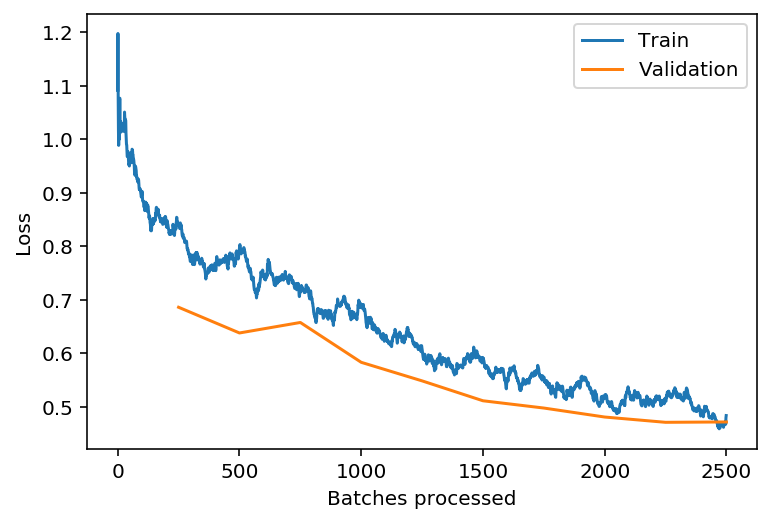

In [45]:
learn.recorder.plot_losses()

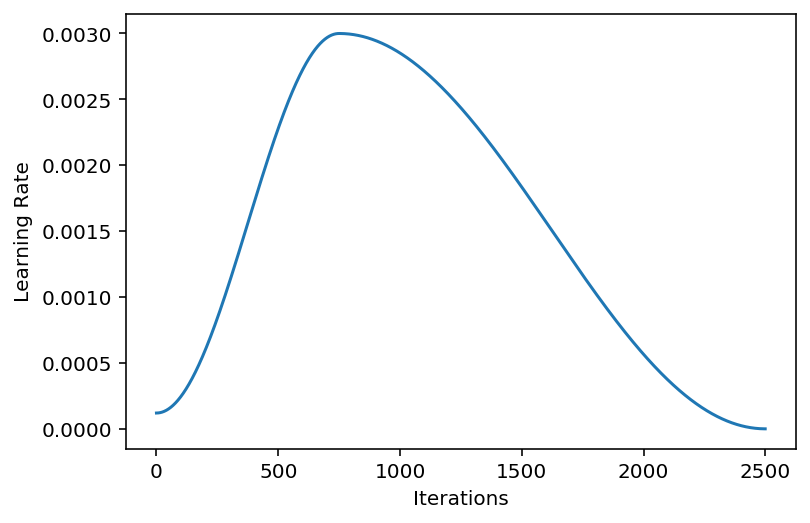

In [46]:
learn.recorder.plot_lr()